In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

import os

path = "/content/drive/九步/4"
os.chdir(path)
os.listdir(path)

E: Package 'python-software-properties' has no installation candidate
··········
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


['code',
 'Assignment 04.pdf',
 'lesson04AIV1.7 (1).pdf',
 'mnist',
 'model_params.pkl',
 'train.ipynb']

In [5]:
import numpy as np
import keras as kr
import torch
import torch.utils.data as Data #将数据分批次需要用到

#读取分目录 固定
def read_category():
  categories = ['体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐']
  categories = [x for x in categories]
  cat_to_id = dict(zip(categories, range(len(categories)))) 
  return categories, cat_to_id

def read_vocab(vocab_dir):
  with open(vocab_dir, 'r', encoding='utf-8', errors='ignore') as fp:
    words = [_.strip() for _ in fp.readlines()]
  word_to_word = dict(zip(words, range(len(words))))
  return words, word_to_word

#将文件转换为id表示
def process_file(filename, word_to_id, cat_to_id, max_length=600):
    contents, labels = [], []
    with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            try:
                label, content = line.strip().split('\t')
                if content:
                    contents.append(list(content))
                    labels.append(label)
            except:
                pass
    data_id, label_id = [], []
    for i in range(len(contents)):
        data_id.append([word_to_id[x] for x in contents[i] if x in word_to_id])#将每句话id化
        label_id.append(cat_to_id[labels[i]])#每句话对应的类别的id
    #
    # # 使用keras提供的pad_sequences来将文本pad为固定长度
    x_pad = kr.preprocessing.sequence.pad_sequences(data_id, max_length)
    y_pad = kr.utils.to_categorical(label_id, num_classes=len(cat_to_id))  # 将标签转换为one-hot表示
    #
    return x_pad, y_pad
 

categories, cat_to_id = read_category()
print(categories,cat_to_id)

#获取训练文本中所有出现过的字及其所对应的id
words, word_to_id = read_vocab('./code/cnews/cnews.vocab.txt')
print(words)
print(word_to_id)

#获取字数
vocab_size = len(words)

# 获取训练数据每个字的id和对应标签的one-hot形式
x_train, y_train = process_file('./code/cnews/cnews.train.txt', word_to_id, cat_to_id, 600)
print('x_train=', x_train)
x_val, y_val = process_file('./code/cnews/cnews.val.txt', word_to_id, cat_to_id, 600)

torch.manual_seed(33)
BATCH_SIZE=8


['体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐'] {'体育': 0, '财经': 1, '房产': 2, '家居': 3, '教育': 4, '科技': 5, '时尚': 6, '时政': 7, '游戏': 8, '娱乐': 9}
['<PAD>', '，', '的', '。', '一', '是', '在', '0', '有', '不', '了', '中', '1', '人', '大', '、', '国', '', '2', '这', '上', '为', '个', '“', '”', '年', '学', '时', '我', '地', '和', '以', '到', '出', '来', '会', '行', '发', '：', '对', '们', '要', '生', '家', '他', '能', '也', '业', '金', '3', '成', '可', '分', '多', '现', '5', '就', '场', '新', '后', '于', '下', '日', '经', '市', '前', '过', '方', '得', '作', '月', '最', '开', '房', '》', '《', '高', '9', '8', '.', '而', '比', '公', '4', '说', ')', '将', '(', '都', '资', 'e', '6', '基', '用', '面', '产', '还', '自', '者', '本', '之', '美', '很', '同', '', '7', '部', '进', '但', '主', '外', '动', '机', '元', '理', '加', 'a', '全', '与', '实', '影', '好', '小', '间', '其', '天', '定', '表', '力', '如', '次', '合', '长', 'o', '体', '价', 'i', '所', '内', '子', '目', '电', '-', '当', '度', '品', '看', '期', '关', '更', 'n', '等', '工', '然', '斯', '重', '些', '球', '此', '里', '利', '相', '情', '投', '点', '没', '因', '已', '三', 

In [0]:
# TextRNN Model
import torch
from torch import nn
import torch.nn.functional as F
 
# 文本分类，RNN模型
class TextRNN(nn.Module):   
    def __init__(self):
        super(TextRNN, self).__init__()
        # 进行词嵌入
        self.embedding = nn.Embedding(5000, 64)  
        # self.rnn = nn.LSTM(input_size=64, hidden_size=128, num_layers=2, bidirectional=True)
        self.rnn = nn.GRU(input_size=64, hidden_size=128, num_layers=2, bidirectional=True)
        self.f1 = nn.Sequential(nn.Linear(256,128),
                                nn.Dropout(0.8),
                                nn.ReLU())
        self.f2 = nn.Sequential(nn.Linear(128,10),
                                nn.Softmax())
 
    def forward(self, x):
        x = self.embedding(x)
        x,_ = self.rnn(x)
        x = F.dropout(x,p=0.8)
        x = self.f1(x[:,-1,:])
        return self.f2(x)


x_train= [[1609  659   56 ...    9  311    3]
 [   2  101   16 ... 1168    3   24]
 [ 465  855  521 ...  116  136   85]
 ...
 [  49   18   79 ...  836 1928 1072]
 [ 166  110  714 ...  836 1928 1072]
 [   1   80  551 ...   78  192    3]]
epoch: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss= tensor(0.7344, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.12
loss= tensor(0.7350, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.09
loss= tensor(0.7345, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.108
loss= tensor(0.7333, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.142
loss= tensor(0.7302, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.21
loss= tensor(0.7275, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.224
loss= tensor(0.7269, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.23
loss= tensor(0.7235, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.27
loss= tensor(0.7242, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.268
loss= tensor(0.7210, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.286
loss= tensor(0.7210, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.284
loss= tensor(0.7220, device='cuda:0', grad_fn=<MeanBackward0>)
accuracy= 0.288
loss= tensor(0.7214, device='cuda:0', grad_fn=<MeanBackwa

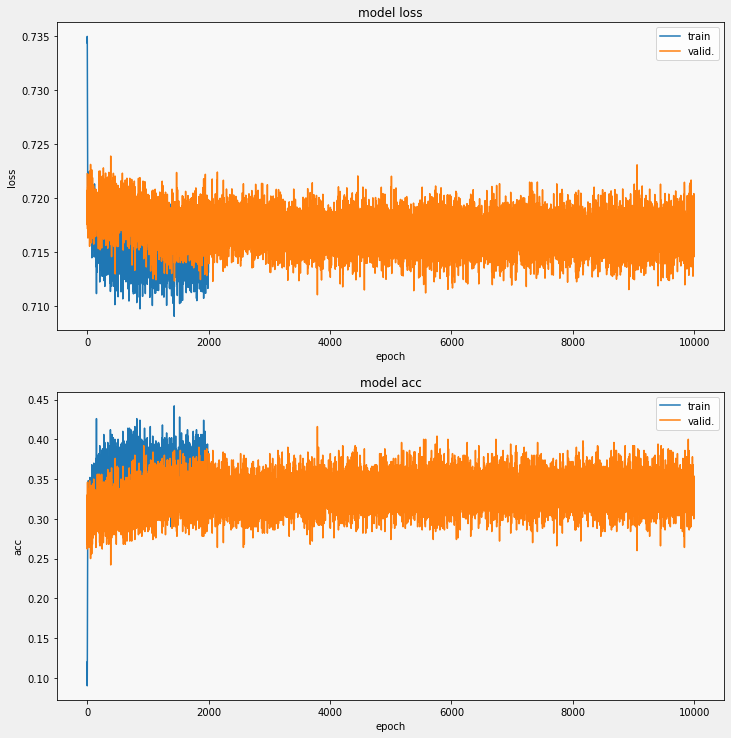

In [10]:
import torch
from torch import nn
from torch import optim
import numpy as np
#from model import TextRNN
#from cnews_loader import read_category, read_vocab, process_file
import torch.utils.data as Data #将数据分批次需要用到
import matplotlib.pyplot as plt

train_file = 'cnews.train.txt'
test_file = 'cnews.test.txt'
val_file = 'cnews.val.txt'
vocab_file = 'cnews.vocab.txt'

train_loss = []
val_loss = []
train_acc = []
val_acc = []

cuda = torch.device('cuda')

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call # 在第一次调用该函数时设置子图
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot) #设置子图
    ax.set_facecolor('#F8F8F8') #设置背景颜色
    ax.plot(training) #画训练集的曲线
    ax.plot(validation) #画测试集的曲线
    ax.set_title('model '+ title)
    ax.set_ylabel(title) #设置y轴标题
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch') #设置x轴标题
    ax.legend(['train', 'valid.']) #设置图例
    plt.savefig("model.png")

def train():
  #使用TextRNN
  model = TextRNN().cuda()
  #损失函数
  Loss = nn.MultiLabelSoftMarginLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  best_val_acc = 0
  for epoch in range(20):
    print('epoch:', epoch+1)
    for step, (x_batch, y_batch) in enumerate(train_loader):
      x = x_batch.cuda()
      y = y_batch.cuda()
      out = model(x)
      loss = Loss(out, y)
      print('loss=', loss)
      train_loss.append(loss)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #计算准确率
      accuracy = np.mean((torch.argmax(out,1) == torch.argmax(y,1)).cpu().numpy())
      print('accuracy=', accuracy)
      train_acc.append(accuracy)
      #对模型进行验证
      if (epoch+1)%2 == 0:
        with torch.no_grad():
          for step, (x_batch, y_batch) in enumerate(val_loader):
            x = x_batch.cuda()
            y = y_batch.cuda()
            out = model(x)
            loss_val = Loss(out, y)
            val_loss.append(loss_val)
            accuracy = np.mean((torch.argmax(out,1) == torch.argmax(y,1)).cpu().numpy())
            val_acc.append(accuracy)
            if accuracy > best_val_acc:
              torch.save(model.state_dict(), 'model_params.pkl')
              best_val_acc = accuracy
              print('val_accuracy=', accuracy)
  display_training_curves(train_loss, val_loss, 'loss', 211)
  display_training_curves(train_acc, val_acc, 'acc', 212)

if __name__=="__main__":
	# 获取文本的类别及其对应id的字典
	categories, cat_to_id = read_category()
	#print(categories)
	# 获取训练文本中所有出现过的字及其所对应的id
	words, word_to_id = read_vocab('./code/cnews/cnews.vocab.txt')
	#print(words)
	#print(word_to_id)
	#print(word_to_id)
	#获取字数
	vocab_size = len(words)

	# 数据加载及分批
	# 获取训练数据每个字的id和对应标签的one-hot形式
	x_train, y_train = process_file('./code/cnews/cnews.train.txt', word_to_id, cat_to_id, 600)
	print('x_train=', x_train)
	x_val, y_val = process_file('./code/cnews/cnews.val.txt', word_to_id, cat_to_id, 600)

	x_train, y_train = torch.LongTensor(x_train), torch.Tensor(y_train)
	x_val, y_val = torch.LongTensor(x_val), torch.Tensor(y_val)

	#数据分批
	train_dataset = Data.TensorDataset(x_train, y_train)
	train_loader = Data.DataLoader(dataset=train_dataset, batch_size=500, shuffle=True, num_workers=2)

	val_dataset = Data.TensorDataset(x_val, y_val)
	val_loader = Data.DataLoader(dataset=val_dataset, batch_size=500, shuffle=True, num_workers=2)
	
	train()

In [11]:
import keras as kr
import torch
from torch import nn
#from cnews_loader import read_category, read_vocab
#from model import TextRNN
import numpy as np
 
vocab_file = './code/cnews/cnews.vocab.txt'
 
class RnnModel:
    def __init__(self):
        self.categories, self.cat_to_id = read_category()
        self.words, self.word_to_id = read_vocab(vocab_file)
        self.model = TextRNN()
        self.model.load_state_dict(torch.load('model_params.pkl'))
 
    def predict(self, message):
        content = message
        data = [self.word_to_id[x] for x in content if x in self.word_to_id]
        data = kr.preprocessing.sequence.pad_sequences([data], 600)
        data = torch.LongTensor(data)
        y_pred_cls = self.model(data)
        class_index = torch.argmax(y_pred_cls[0]).item()
        return self.categories[class_index]
 
 
if __name__ == '__main__':
    model = RnnModel()
    test_demo = ['《时光重返四十二难》恶搞唐增取经一款时下最热门的动画人物：猪猪侠，加上创新的故事背景，震撼的操作快感，成就了这部恶搞新作，现正恶搞上市，玩家们抢先赶快体验快感吧。游戏简介：被时光隧道传送到208年的猪猪侠，必须经历六七四十二难的考验，才能借助柯伊诺尔大钻石的力量，开启时光隧道，重返2008年。在迷糊老师、菲菲公主的帮助下，猪猪侠接受了挑战，开始了这段充满了关心和情谊的旅程。    更多精彩震撼感觉，立即下载该款游戏尽情体验吧。玩家交流才是王道，讯易游戏玩家交流中心 QQ群：6306852-----------------生活要有激情，游戏要玩多彩(多彩游戏)。Colourfulgame (多彩游戏)，让你看看快乐游戏的颜色！精品推荐：1：《钟馗传》大战无头关羽，悲壮的剧情伴随各朝英灵反攻地府！2：《中华群英》将和赵云，项羽，岳飞等猛将作战，穿越各朝代抗击日寇。良品推荐：1：《赌王争霸之斗地主》易飞会在四角恋中会选择谁？是否最终成赌神呢？2：勇者后裔和魔王紧缠一起，前代恩怨《圣火伏魔录》将为您揭示一切。  3：颠覆传统概念，恶搞+非主流？！誓必弄死搞残为止《爆笑飞行棋》。4：《中国象棋残局大师》快棋和人机模式让畅快对弈！一切“多彩游戏”资讯，点击Colourfulgame官网http://www.colourfulgame.com一切“多彩游戏”感言，交流Colourfulgame论坛http://121.33.203.124/forum/【客服邮箱】：xunyiwangluo@126.com">xunyiwangluo@126.com">xunyiwangluo@126.com【客服热线】：020-87588437']
                 
    for i in test_demo:
      print(i,":",model.predict(i))

《时光重返四十二难》恶搞唐增取经一款时下最热门的动画人物：猪猪侠，加上创新的故事背景，震撼的操作快感，成就了这部恶搞新作，现正恶搞上市，玩家们抢先赶快体验快感吧。游戏简介：被时光隧道传送到208年的猪猪侠，必须经历六七四十二难的考验，才能借助柯伊诺尔大钻石的力量，开启时光隧道，重返2008年。在迷糊老师、菲菲公主的帮助下，猪猪侠接受了挑战，开始了这段充满了关心和情谊的旅程。    更多精彩震撼感觉，立即下载该款游戏尽情体验吧。玩家交流才是王道，讯易游戏玩家交流中心 QQ群：6306852-----------------生活要有激情，游戏要玩多彩(多彩游戏)。Colourfulgame (多彩游戏)，让你看看快乐游戏的颜色！精品推荐：1：《钟馗传》大战无头关羽，悲壮的剧情伴随各朝英灵反攻地府！2：《中华群英》将和赵云，项羽，岳飞等猛将作战，穿越各朝代抗击日寇。良品推荐：1：《赌王争霸之斗地主》易飞会在四角恋中会选择谁？是否最终成赌神呢？2：勇者后裔和魔王紧缠一起，前代恩怨《圣火伏魔录》将为您揭示一切。  3：颠覆传统概念，恶搞+非主流？！誓必弄死搞残为止《爆笑飞行棋》。4：《中国象棋残局大师》快棋和人机模式让畅快对弈！一切“多彩游戏”资讯，点击Colourfulgame官网http://www.colourfulgame.com一切“多彩游戏”感言，交流Colourfulgame论坛http://121.33.203.124/forum/【客服邮箱】：xunyiwangluo@126.com">xunyiwangluo@126.com">xunyiwangluo@126.com【客服热线】：020-87588437 : 游戏


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
